In [27]:
import numpy as np
import h5py
import unet_uae_save_r_u_net as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam, SGD
import tensorflow as tf 
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated

config.gpu_options.per_process_gpu_memory_fraction = 0.5
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [28]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [29]:
data_dir = '/data3/Astro/cnn_surrogate_meng/topics/channel_80x80_l100_10step_2000days/data/'
# load training data
data_path = os.path.join(data_dir, 'channel_80x80_25w_lhs2967_bhp3_2000d_runs_3.h5')
p_t, sat_t, logk = load_data(data_path, ['pressure', 'sat', 'logk'])
# load eval data
print('p_t shape is ', p_t.shape)
print('sat_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)

p_t shape is  (2967, 41, 80, 80)
sat_t shape is  (2967, 41, 80, 80)
logk shape is  (2967, 1, 80, 80)


In [30]:
sat_t[sat_t < 0.1] = 0.1
sat_t[sat_t > 1] = 1.0

In [31]:
depth = 10
nr = logk.shape[0]
train_nr = 1500
test_nr = 500

In [32]:
# data whitening
p_t_mean = np.mean(p_t[:train_nr, ...], axis = 0, keepdims = True)
#p_t_std = np.std(p_t[:train_nr, ...], axis = 0, keepdims = True)
#p_t = (p_t - p_t_mean) #/ p_t_std
p_t = p_t - p_t_mean
print('max p is ', np.max(p_t[:train_nr, ...]), ', min p is ', np.min(p_t[:train_nr, ...]))
max_p = np.max(p_t[:train_nr, ...])
min_p = np.min(p_t[:train_nr, ...])

max p is  84.27208540634274 , min p is  -90.98400769142245


In [33]:
p_t = (p_t - min_p)/(max_p -min_p) #- 0.5
print('max p is ', np.max(p_t), ', min p is ', np.min(p_t))
print('max p train is ', np.max(p_t[:train_nr, ...]), ', min p rrain is ', np.min(p_t[:train_nr, ...]))

max p is  1.0 , min p is  -0.008138622000617454
max p train is  1.0 , min p rrain is  0.0


In [34]:
step_index = [1, 2, 4, 6, 8, 10, 12, 14, 17, 20]
depth = 10
nr = logk.shape[0]
train_nr = 1500
test_nr = 500
train_x = np.concatenate([logk[:train_nr, ...],sat_t[:train_nr,[0], ...]], axis = 1)
train_y = np.concatenate([sat_t[:train_nr,step_index,:, :, None], p_t[:train_nr,step_index,:, :, None]], axis = -1)

test_x = np.concatenate([logk[nr-test_nr:, ...],  sat_t[nr-test_nr:, [0], ...]], axis = 1)
test_y = np.concatenate([sat_t[nr-test_nr:,step_index, :, :, None], p_t[nr-test_nr:,step_index, :, :, None]], axis = -1)


train_x = train_x.transpose(0,2,3,1)
#train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
#test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (1500, 80, 80, 2)
train_y shape is  (1500, 10, 80, 80, 2)
test_x shape is  (500, 80, 80, 2)
test_y shape is  (500, 10, 80, 80, 2)


In [35]:
input_shape=(80,80,2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)

output shape is  (None, 10, 80, 80, 2)


In [36]:
batch_size = 8
output_dir = 'saved_models/'
#epoch_p=420 
vae_model.load_weights(output_dir + 'saved-model-sat-p-r-u-net-l1l2-500-289.44.h5')

In [37]:
p_pred_list = []
sat_pred_list = []
test_batch_size = 50 
batch_num = int(test_nr / test_batch_size)
for i in range(batch_num):
    pred = vae_model.predict(test_x[i*test_batch_size: (i+1)*test_batch_size, ...])
    p_pred_list.append(pred[:, :, :, :, 1])
    sat_pred_list.append(pred[:, :, :, :, 0])

p_pred = np.concatenate(p_pred_list, axis = 0)
sat_pred = np.concatenate(sat_pred_list, axis = 0)
sat_pred[sat_pred < 0.1] = 0.1

print(p_pred.shape)
print(sat_pred.shape)

(500, 10, 80, 80)
(500, 10, 80, 80)


In [38]:
p_true = test_y[:,:,:,:,1]
sat_true = test_y[:,:,:,:,0]
# p_pred = p_pred[:,:,:,:,0]
# sat_pred = sat_pred[:,:,:,:,0]
print(p_true.shape)
print(sat_true.shape)

(500, 10, 80, 80)
(500, 10, 80, 80)


In [39]:
# convert pressure back to correct range
p_true = ((max_p - min_p) * (p_true)+ min_p)  + p_t_mean[:,step_index, ...]
p_pred = ((max_p - min_p) * (p_pred) + min_p) + p_t_mean[:,step_index, ...]
print(p_pred.shape)

(500, 10, 80, 80)


In [40]:
p_true = p_true.transpose(0,2,3,1)
p_pred = p_pred.transpose(0,2,3,1)
sat_true = sat_true.transpose(0,2,3,1)
sat_pred = sat_pred.transpose(0,2,3,1)

In [41]:
# check if all the predictions are correct
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

ind_case = [0, 1, 3]
num_case = len(ind_case)

<Figure size 432x288 with 0 Axes>

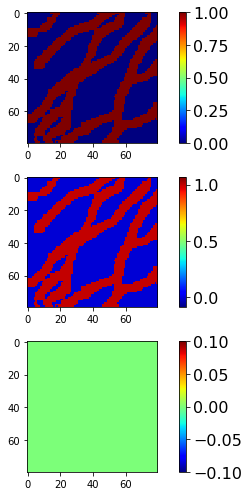

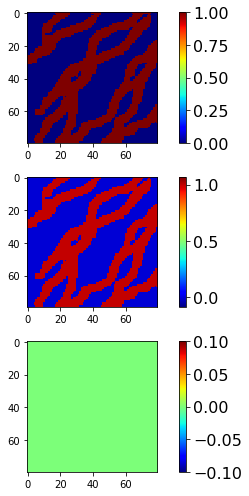

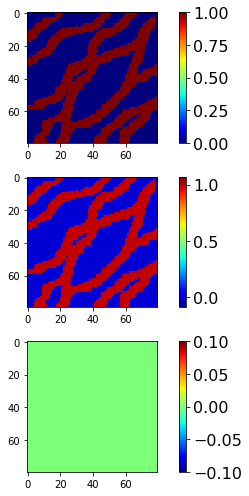

In [42]:
for k in ind_case:
    for i_tstep in range(1):
        plt.figure(figsize=(7,7))
        plt.subplot(3, 1, 1)
        plt.imshow(test_x[k, ::-1, :, 0])
        cbar = plt.colorbar(fraction=0.046)
        cbar.ax.tick_params(labelsize=16)
        plt.tight_layout()
        plt.subplot(3, 1, 2)
        plt.imshow(test_x[k, ::-1, :, 0].reshape((80,80)), vmin=-0.09, vmax=1.07)
        #plt.set_clim([-0.09, 1.07])
        cbar = plt.colorbar(fraction=0.046)
        cbar.ax.tick_params(labelsize=16)
        plt.tight_layout()
        
        plt.subplot(3, 1, 3)
        plt.imshow(test_x[k, ::-1, :, 0].reshape((80,80)) - test_x[k, ::-1, :, i_tstep])
        cbar = plt.colorbar(fraction=0.046)
        cbar.ax.tick_params(labelsize=16)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()
        #plt.savefig('ind_case_%d_logk'%(k),bbox_inches='tight')
plt.show()

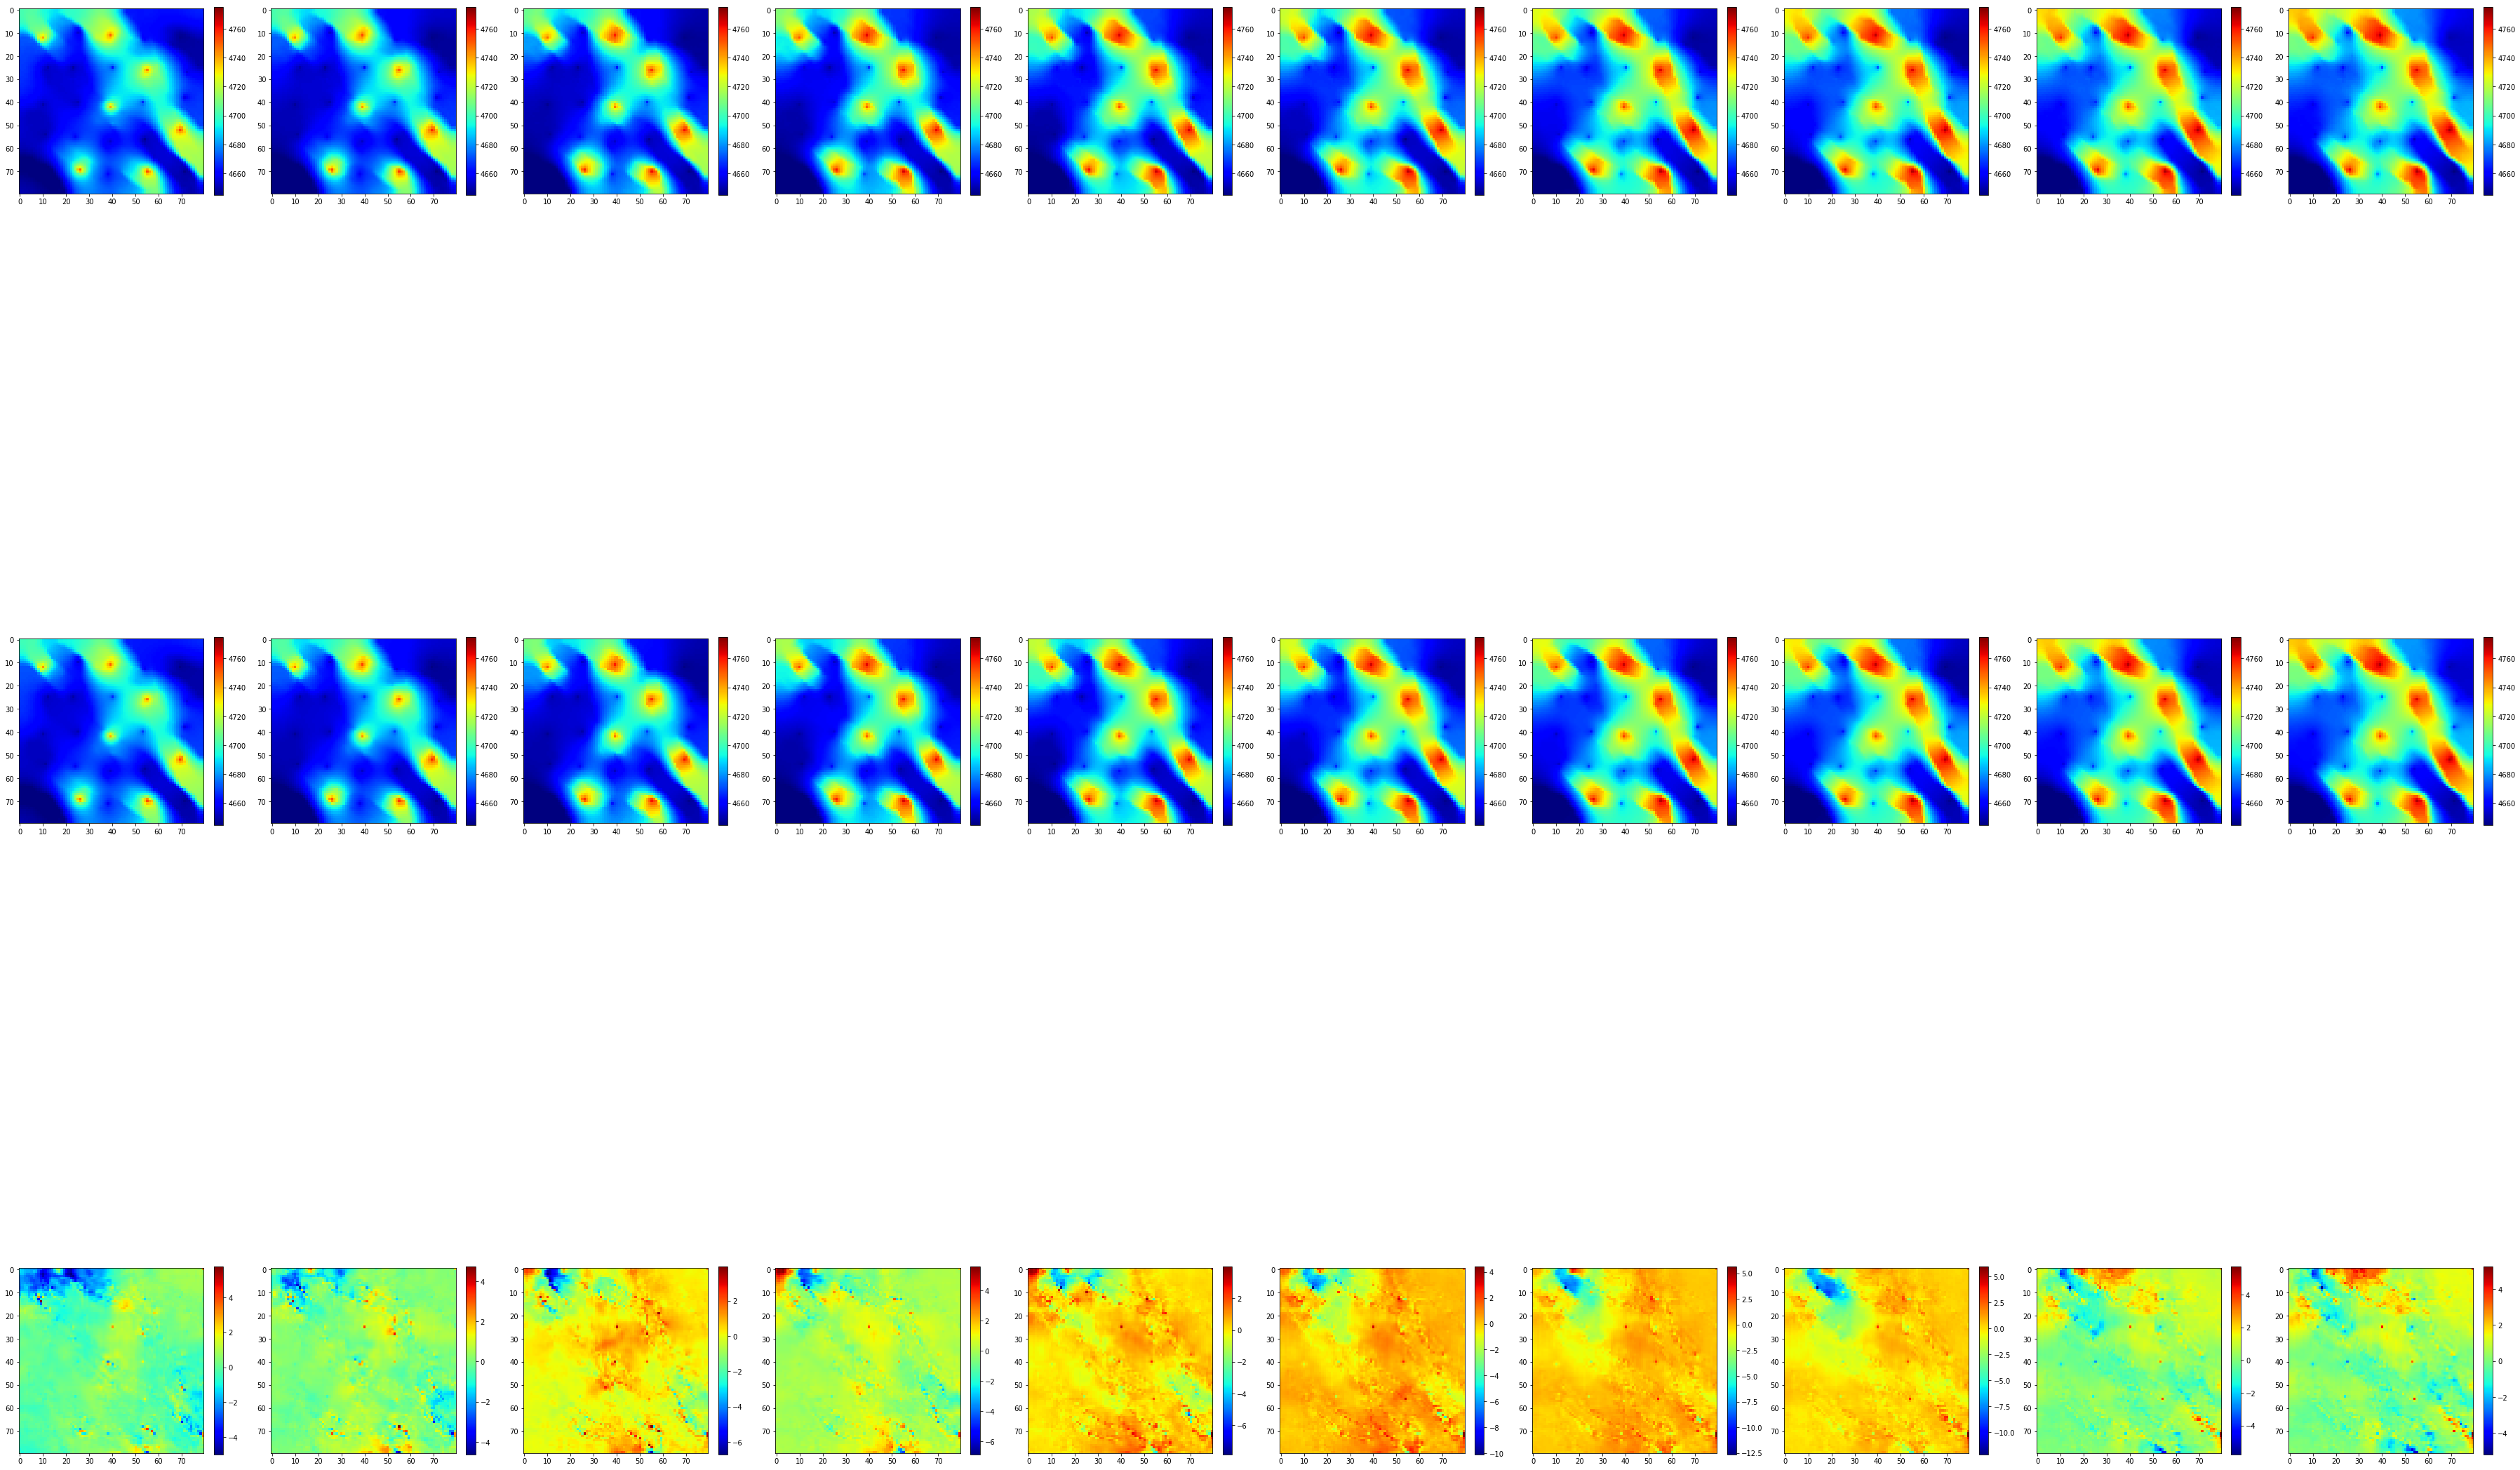

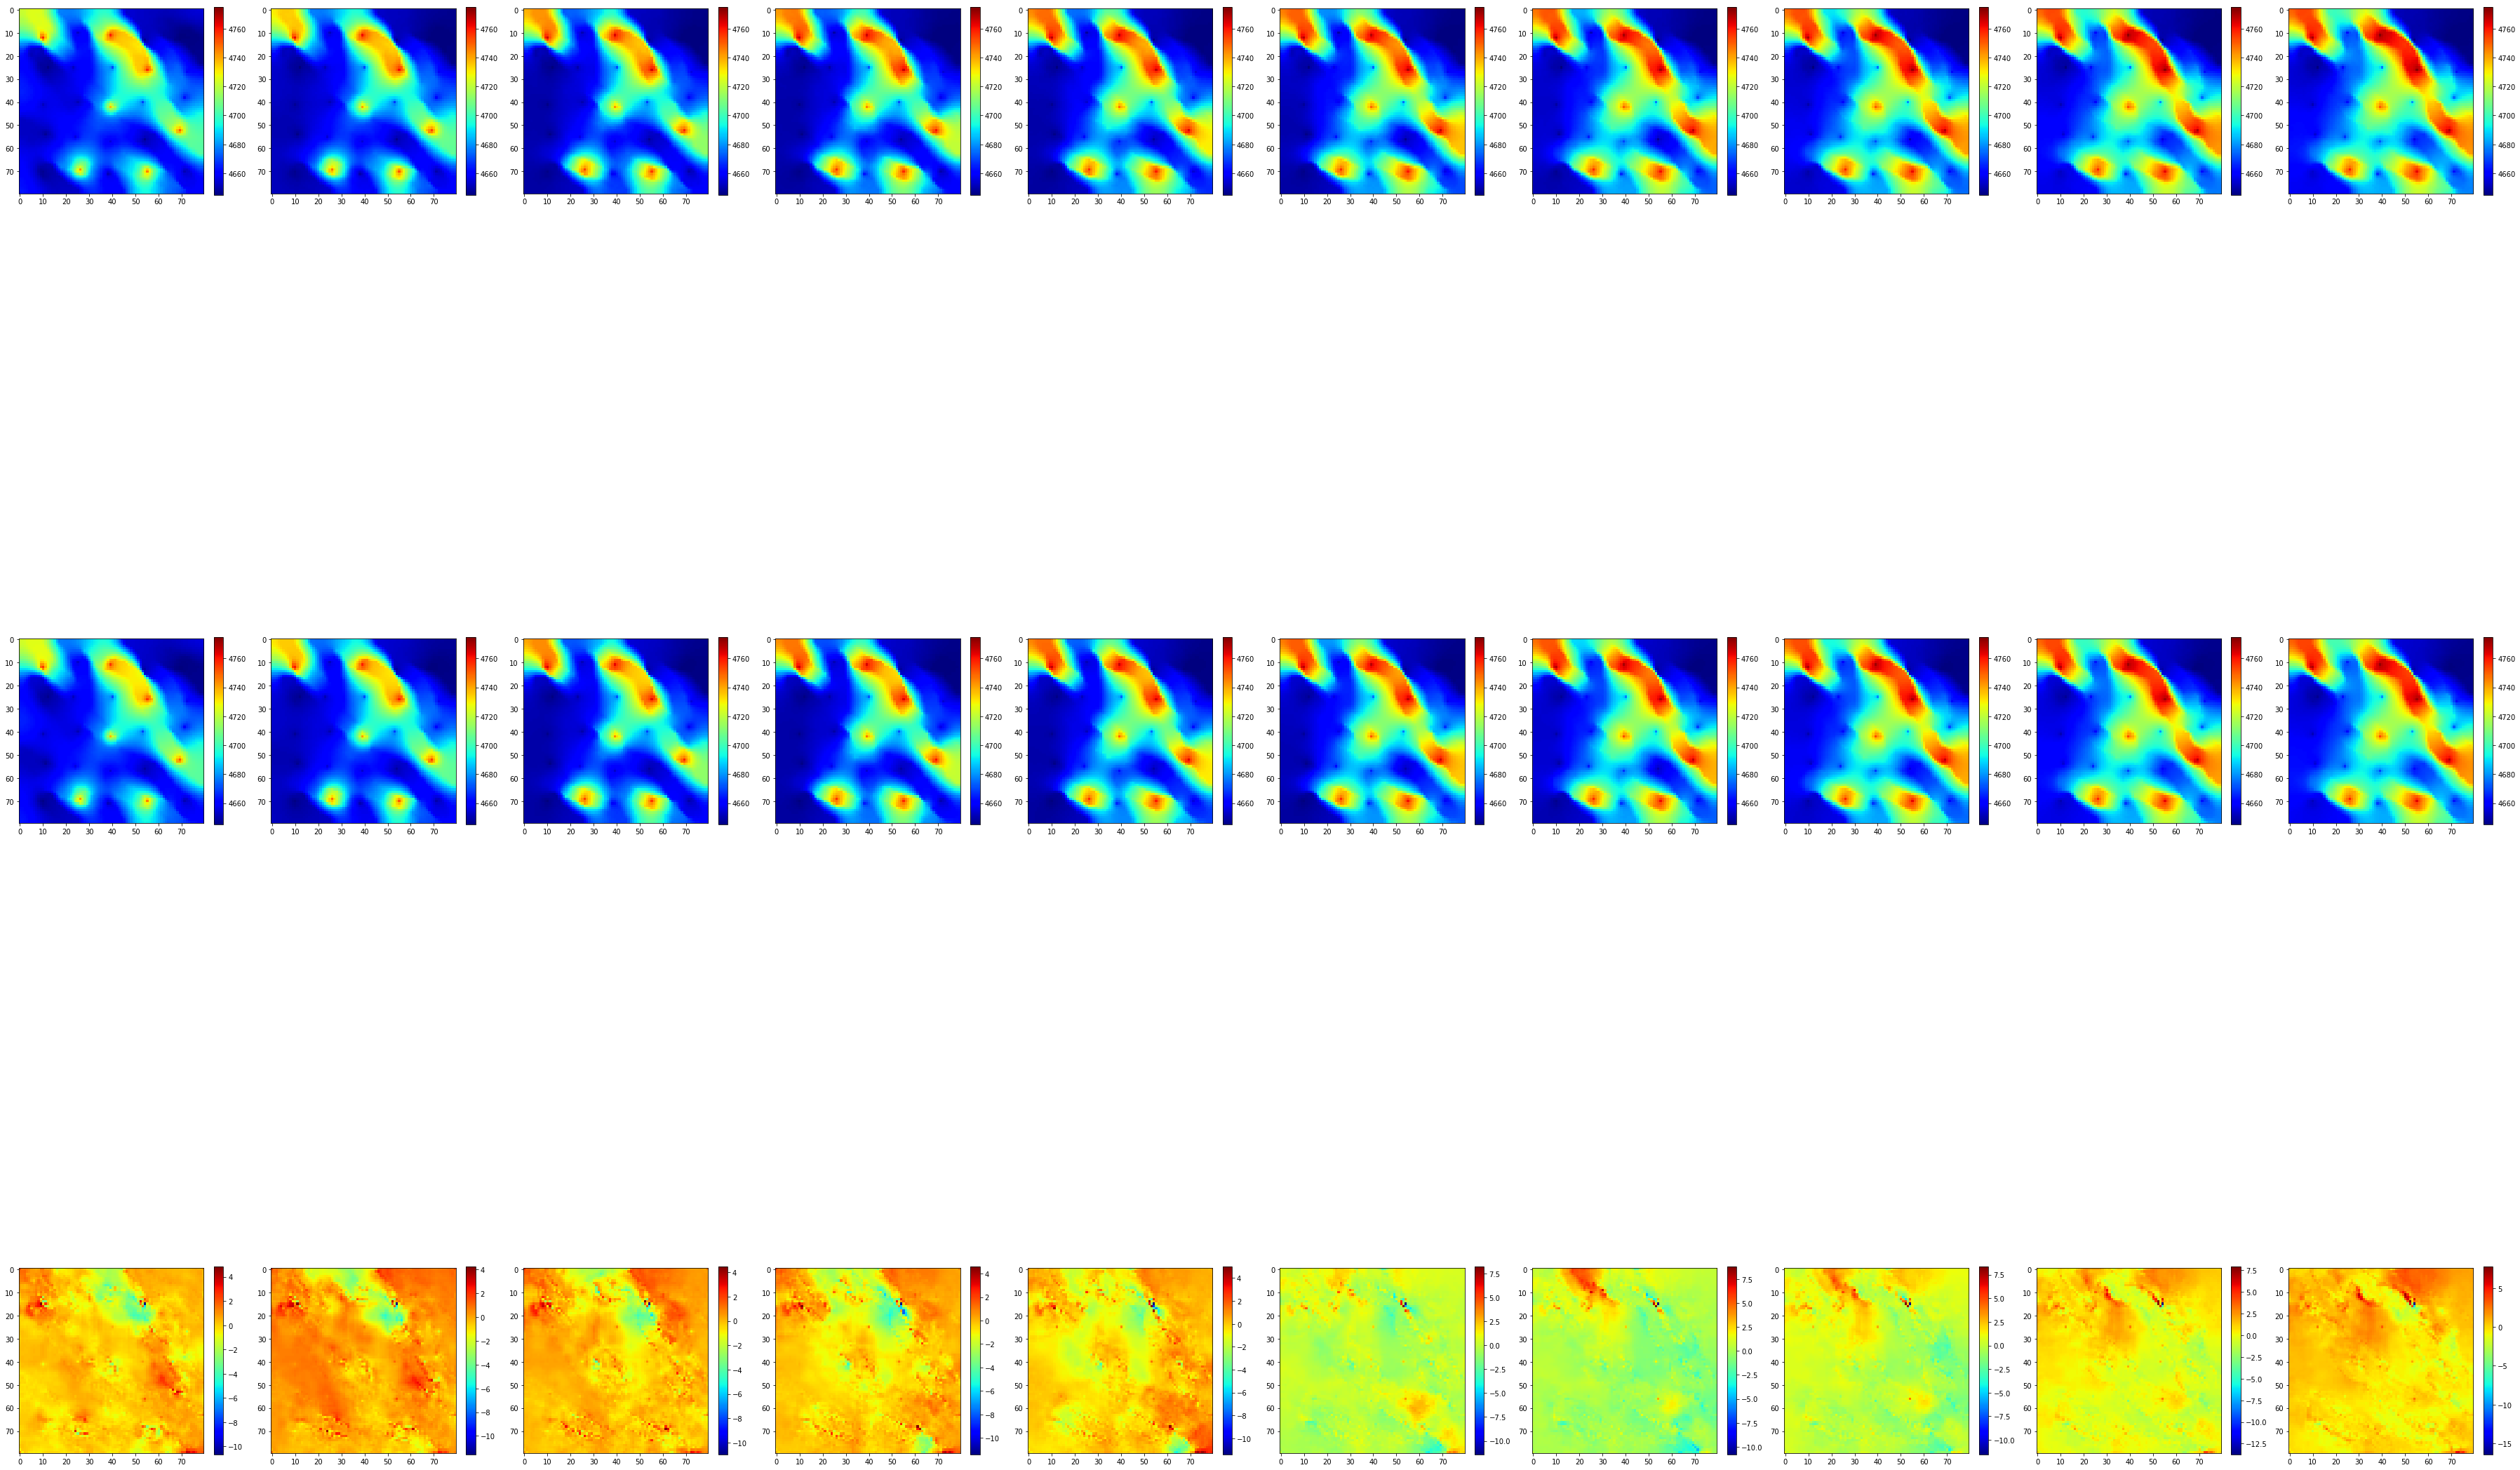

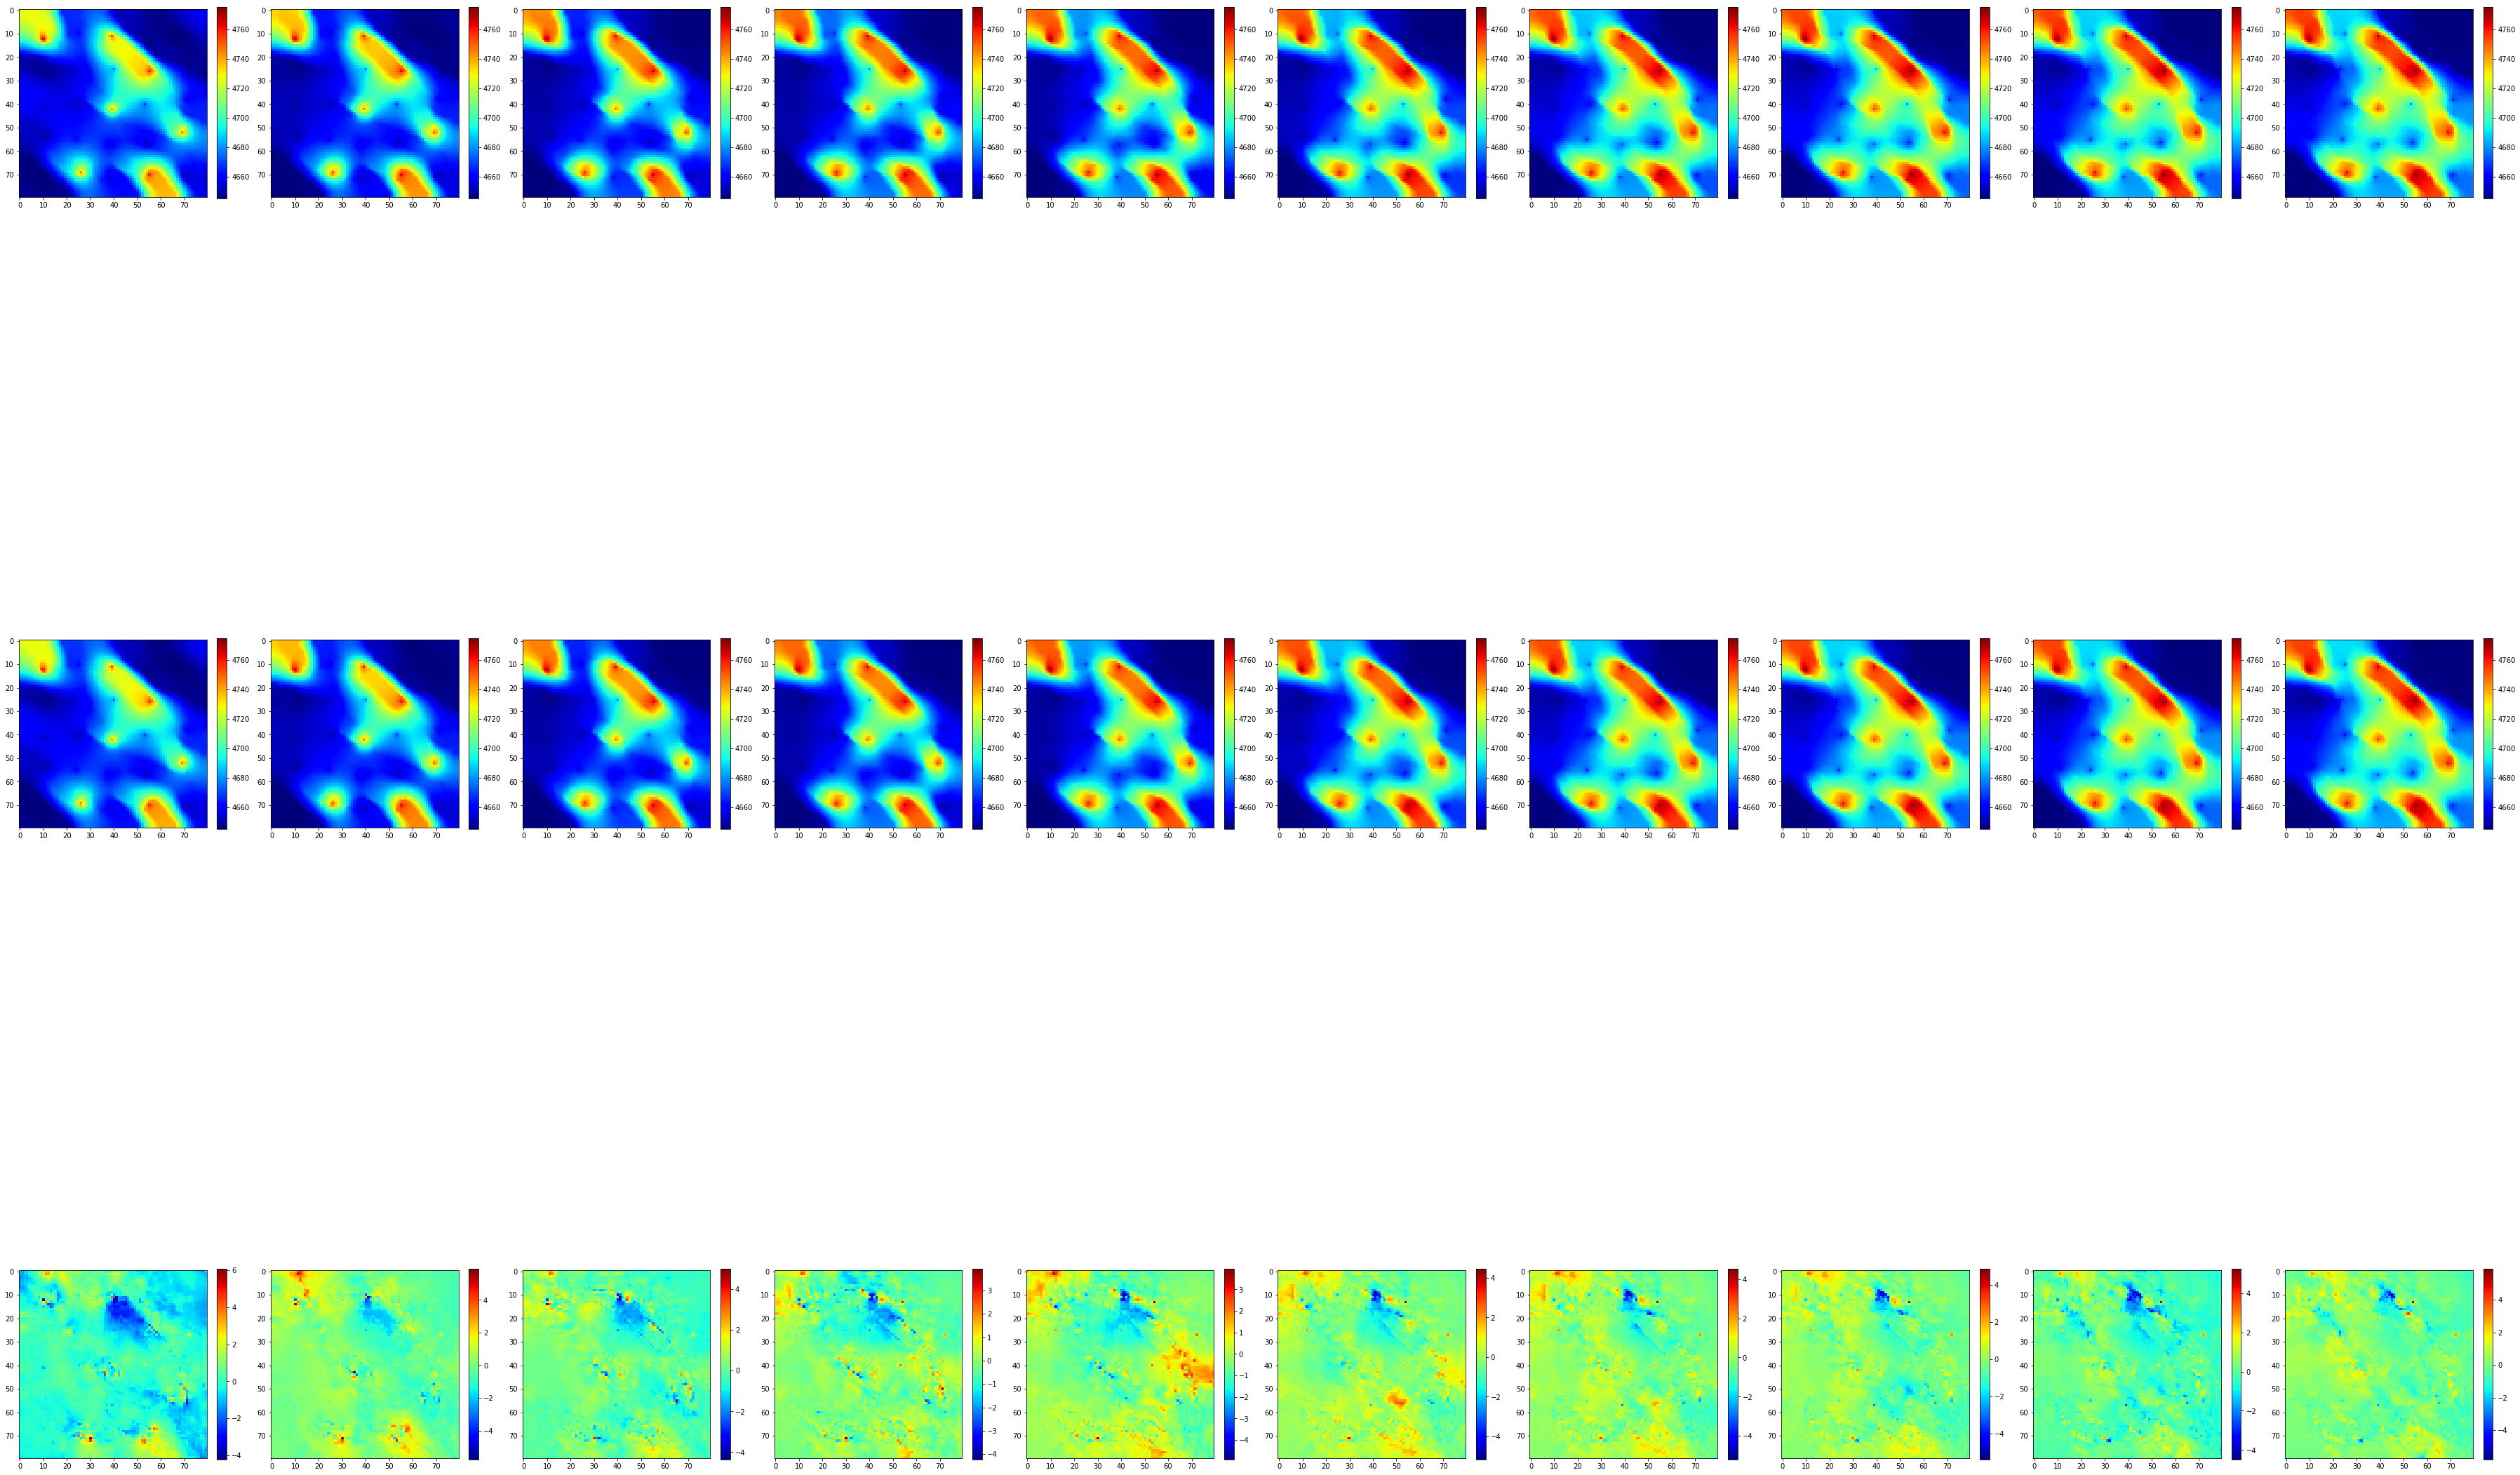

In [43]:
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, :, :, i_tstep], vmin=4645, vmax=4775)
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, :, :, i_tstep].reshape((80,80)), vmin=4645, vmax=4775)
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, :, :, i_tstep].reshape((80,80)) - p_pred[k, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

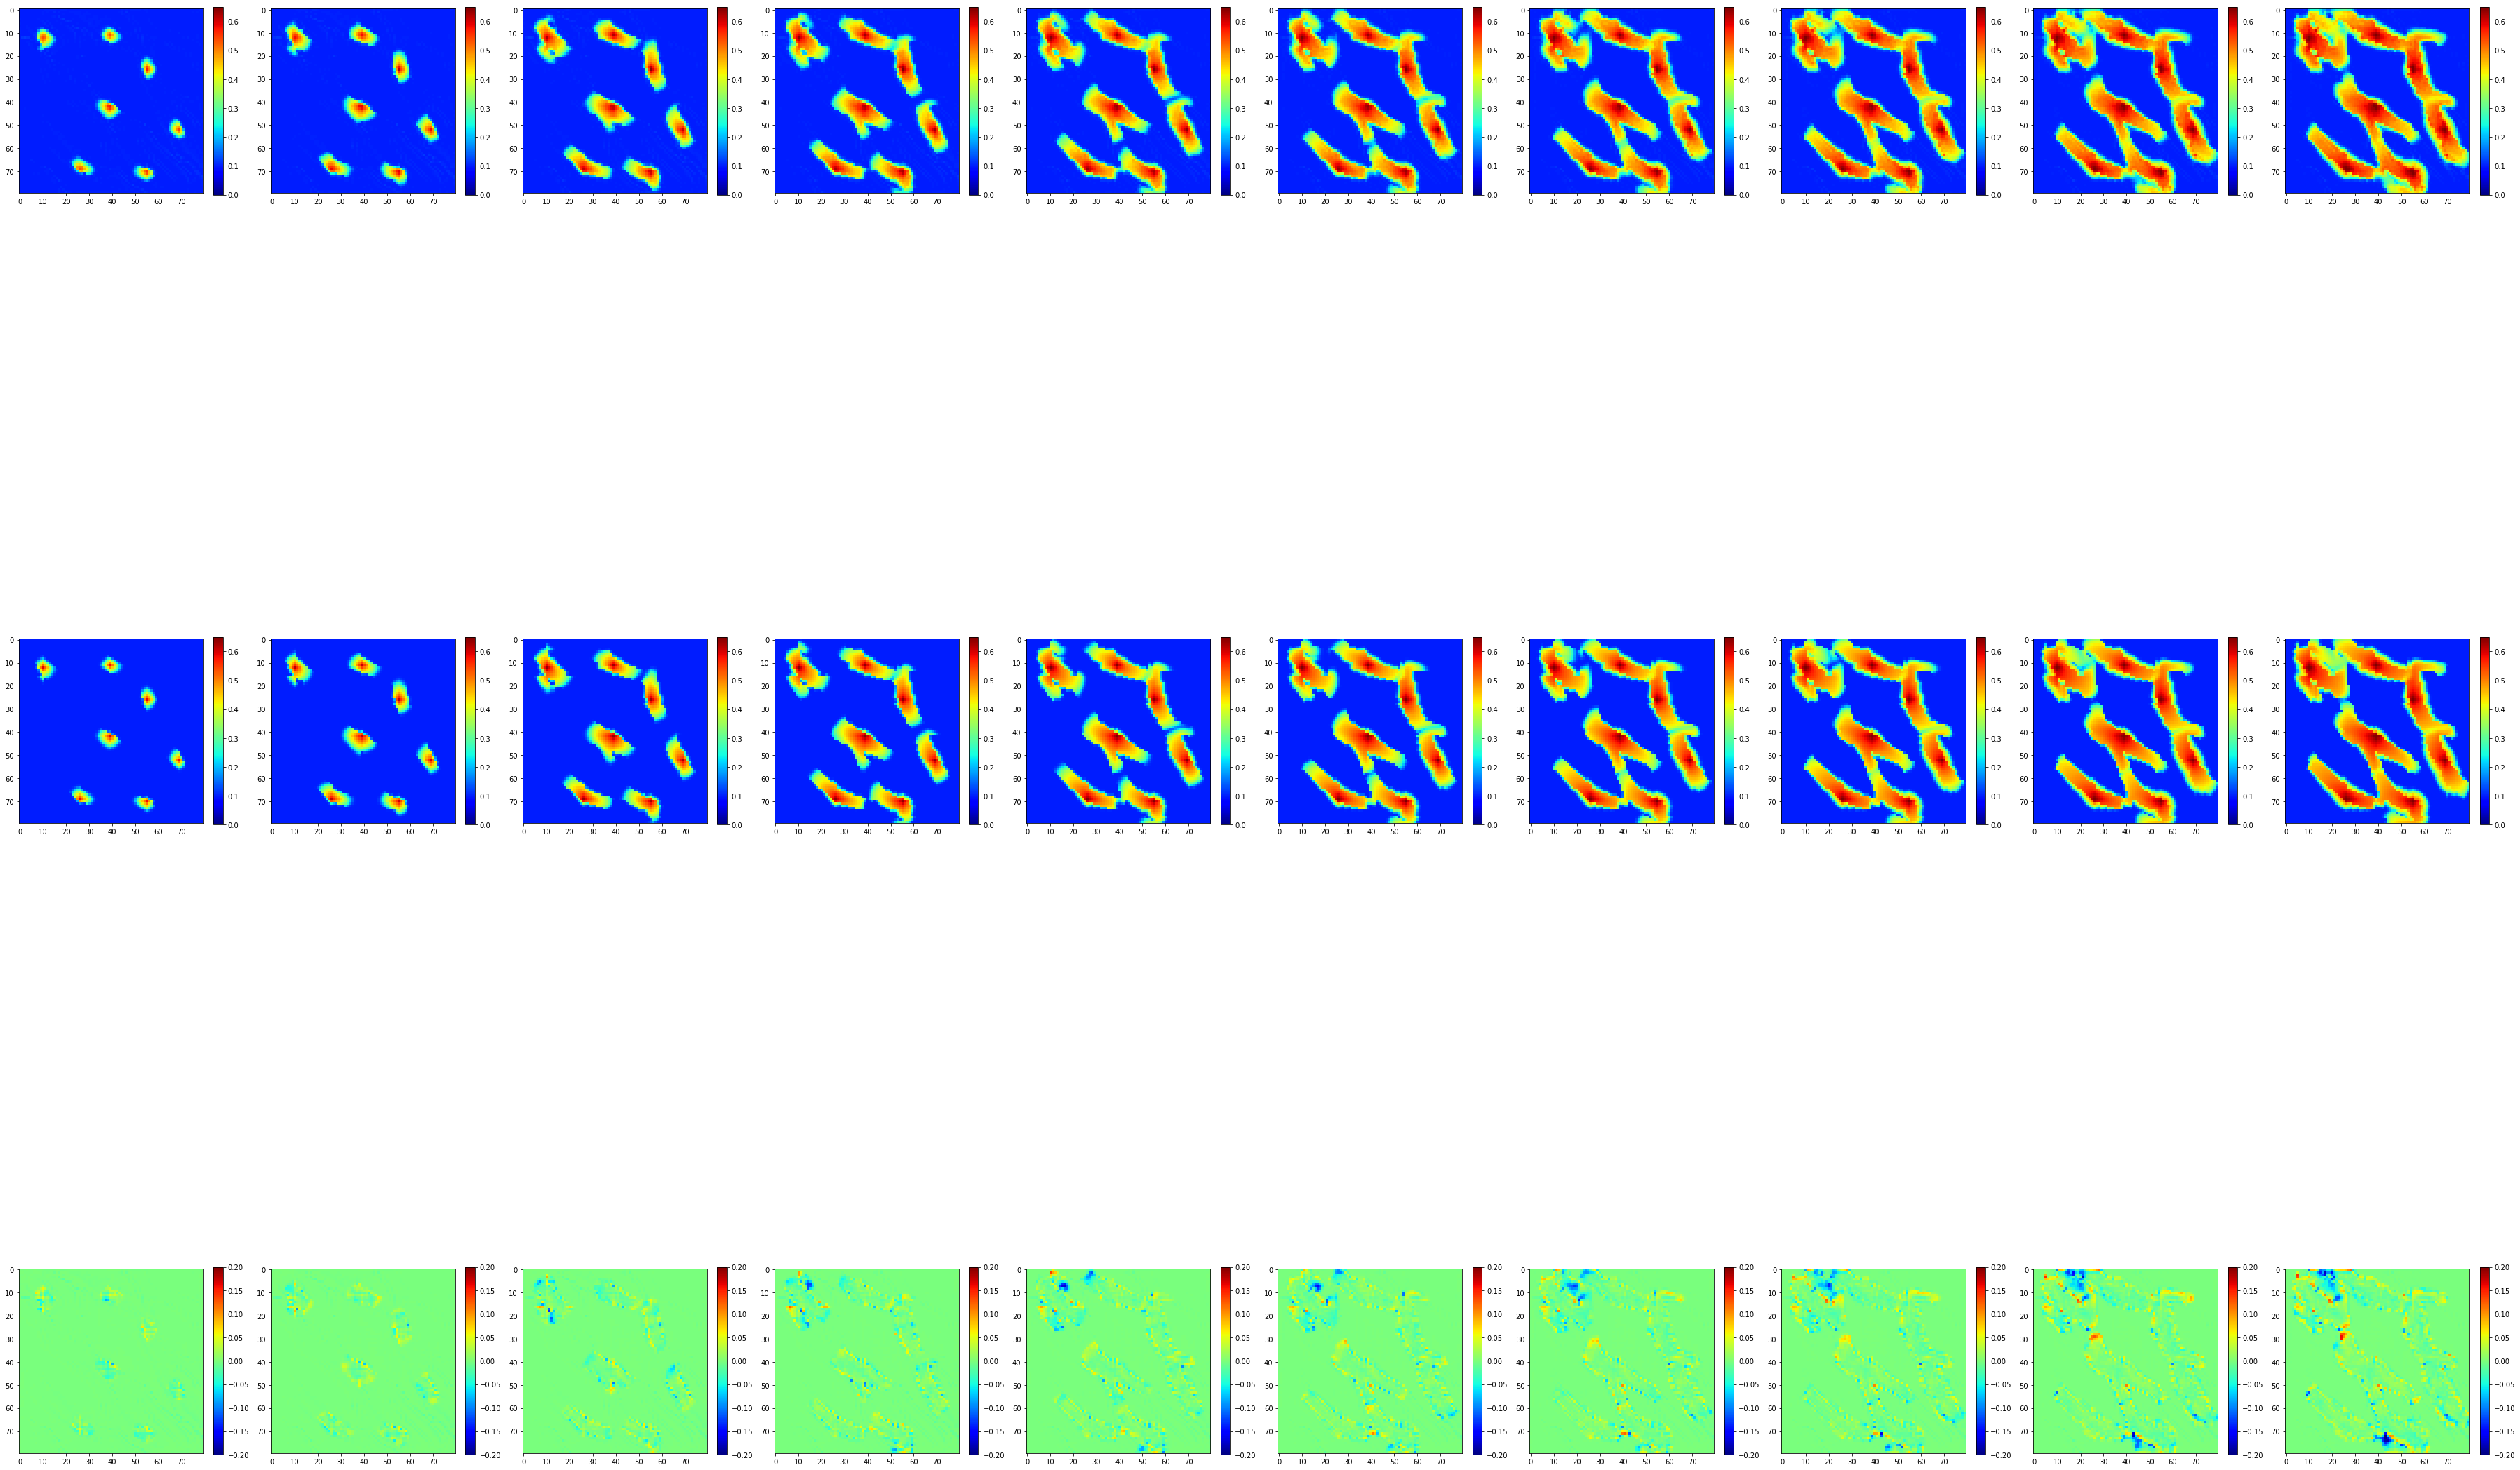

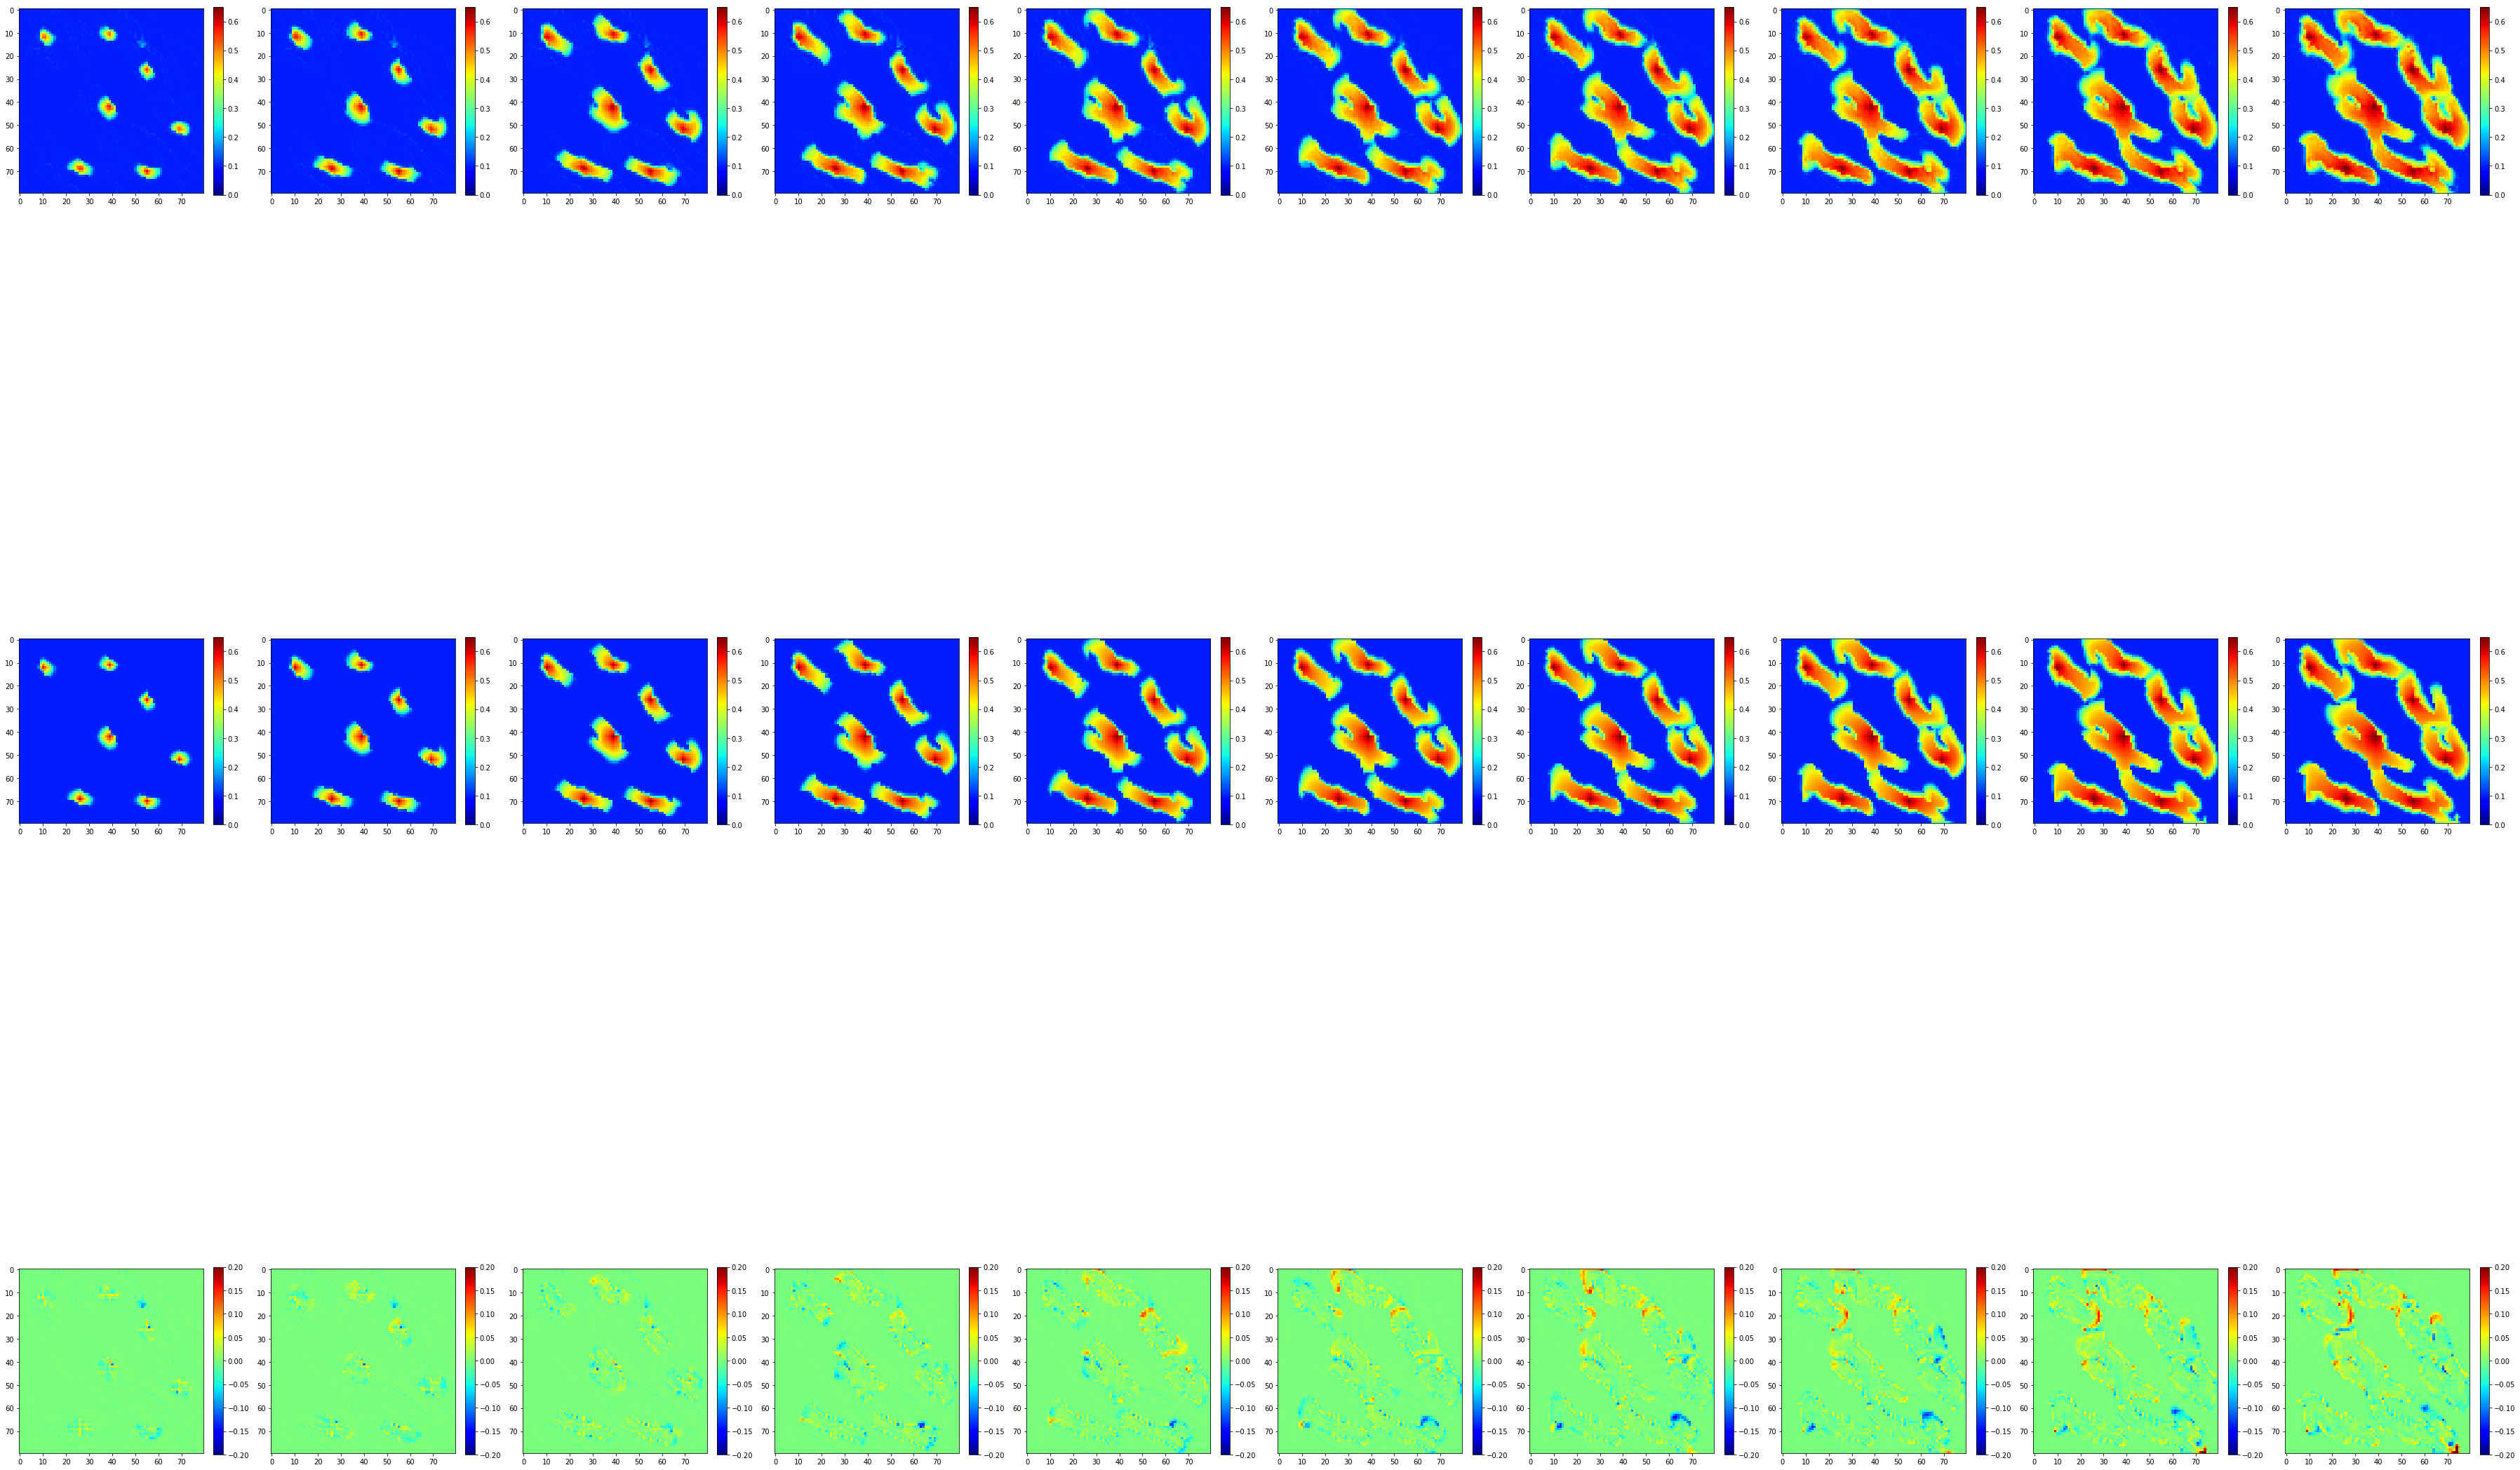

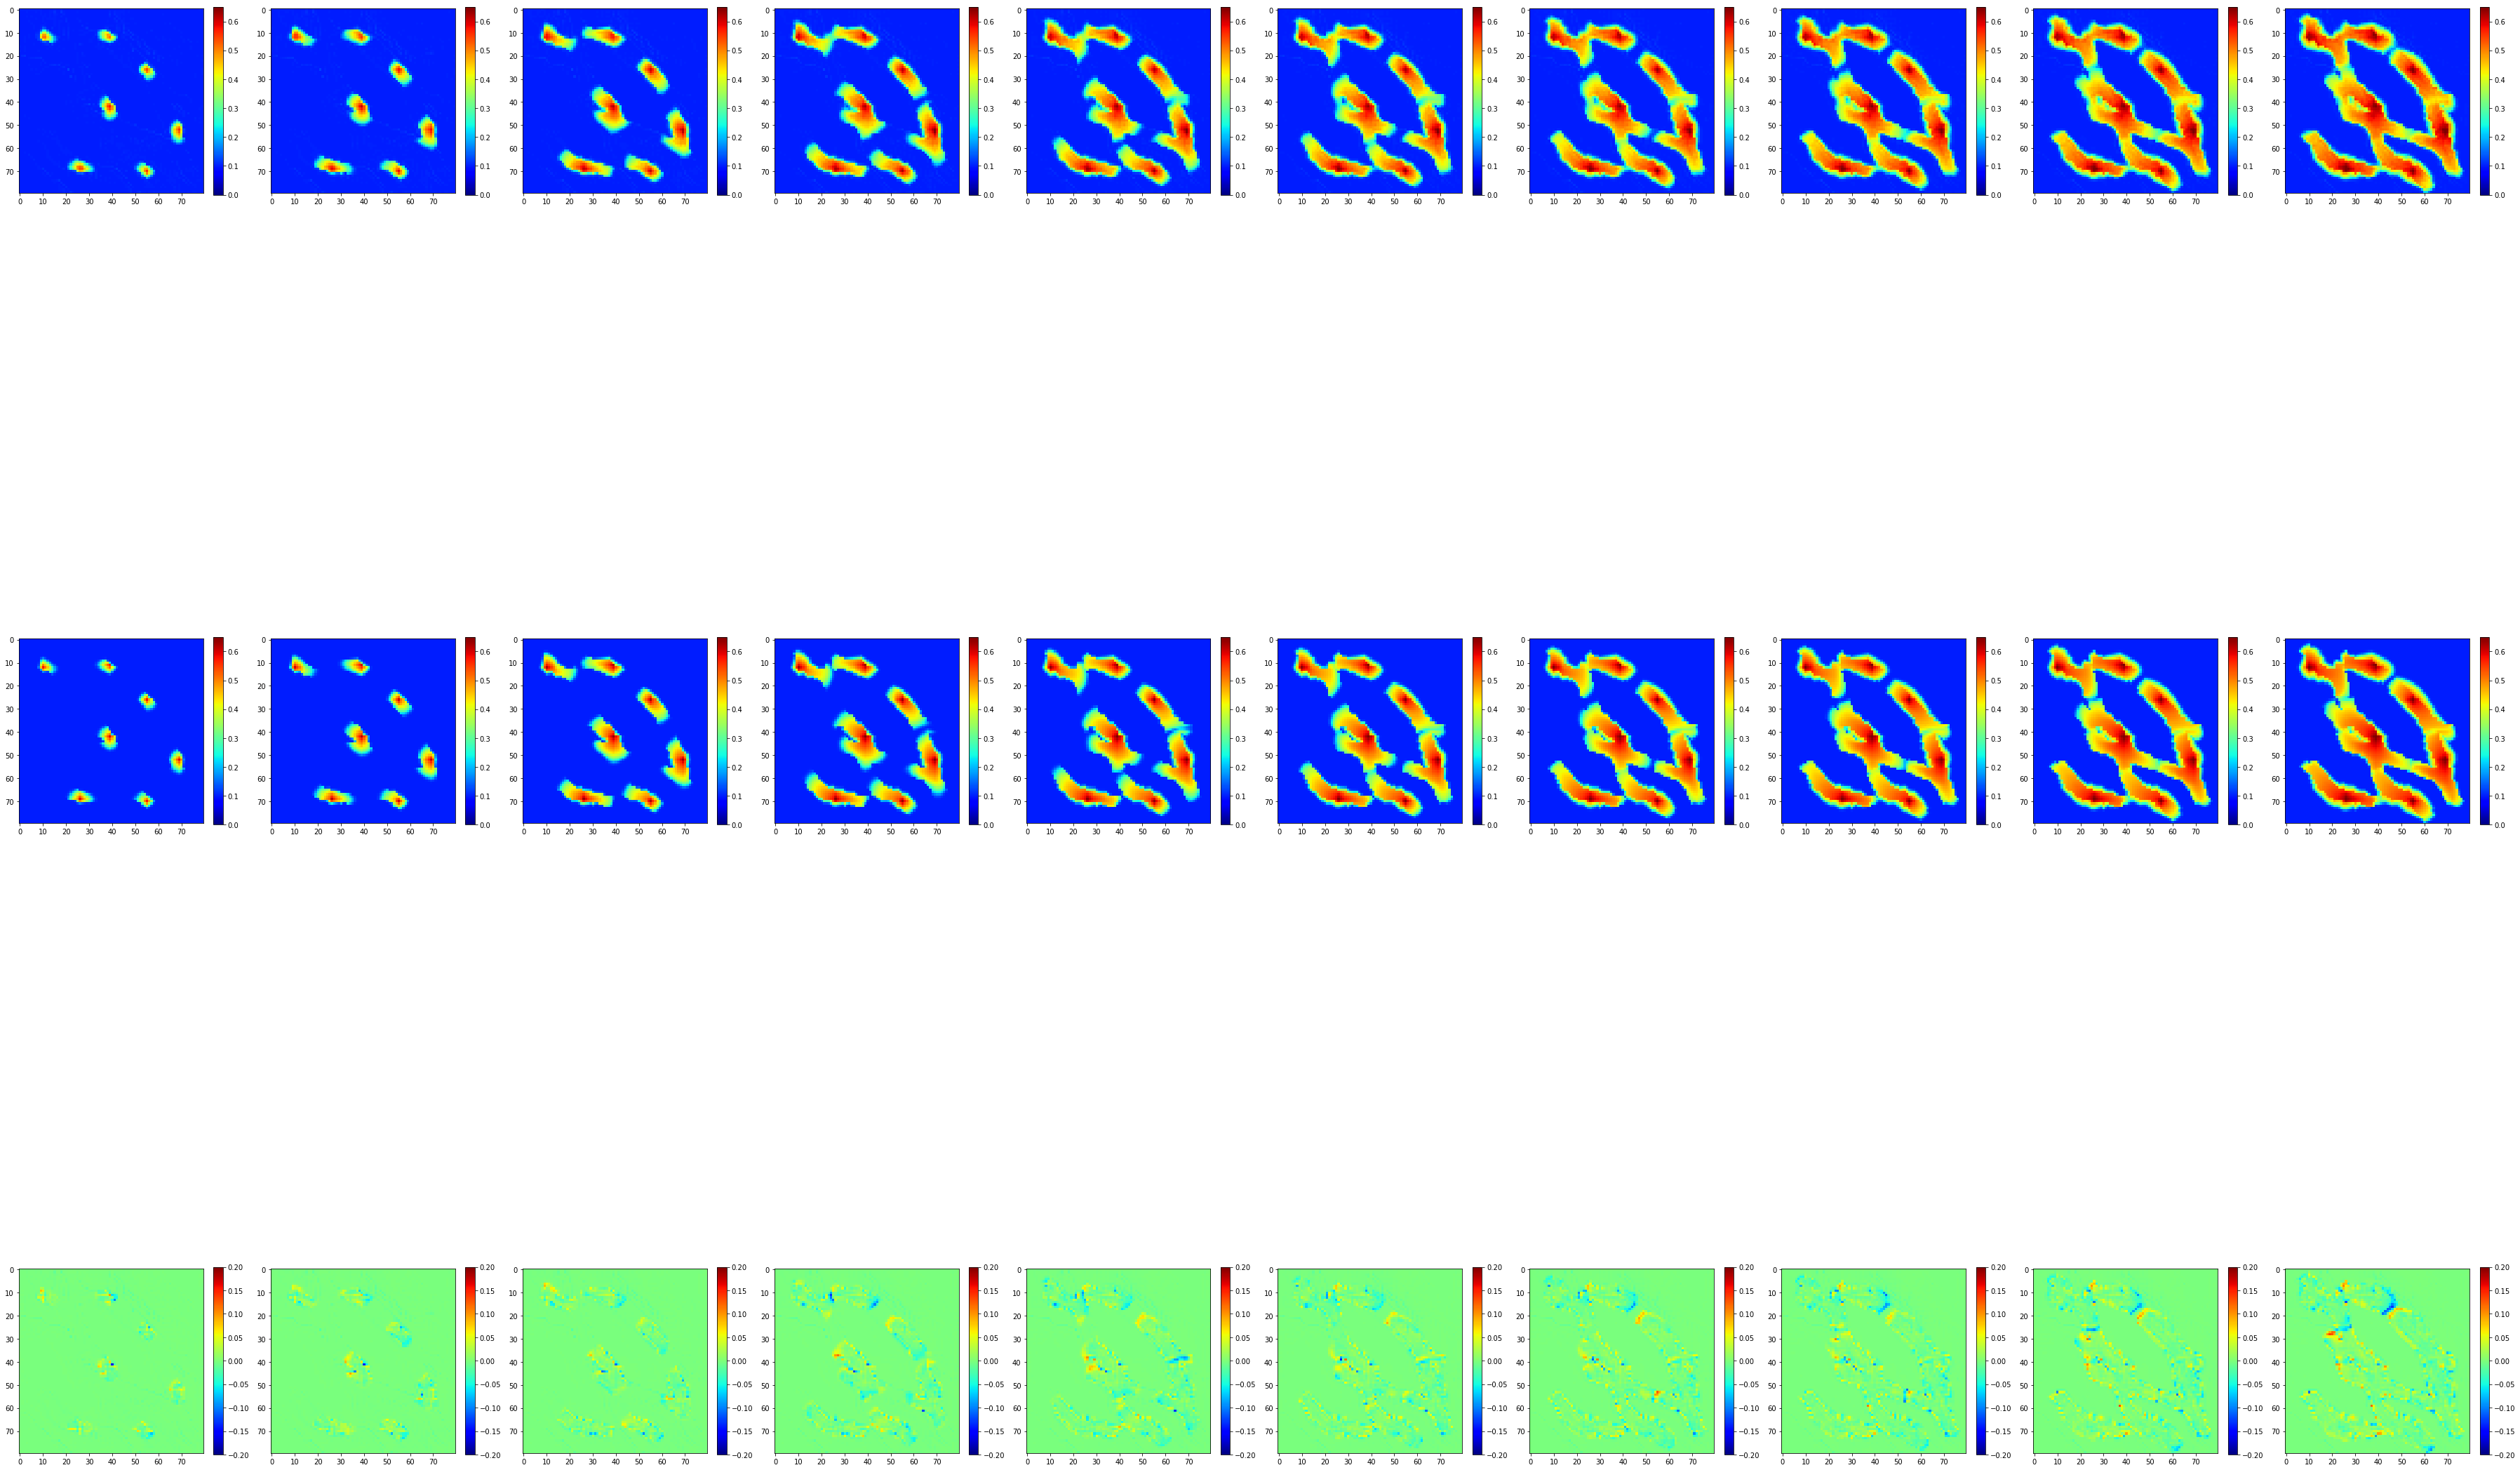

In [44]:
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(sat_pred[k, :, :, i_tstep], vmin=0, vmax=0.65)
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(sat_true[k, :, :, i_tstep].reshape((80,80)), vmin=0, vmax=0.65)
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(sat_true[k, :, :, i_tstep].reshape((80,80)) - sat_pred[k, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

## Compute the relative error of saturation and pressure maps over time

In [45]:
sat_true.shape

(500, 80, 80, 10)

In [46]:
sat_relative_error_time = np.mean(np.abs(sat_true - sat_pred) / sat_true, axis = (0, 1, 2))

In [47]:
sat_relative_error_time

array([0.01545116, 0.01894066, 0.02388626, 0.0283903 , 0.0315763 ,
       0.03408941, 0.03590552, 0.03848609, 0.04143034, 0.04547204])

In [48]:
np.mean(sat_relative_error_time)

0.03136280874887296

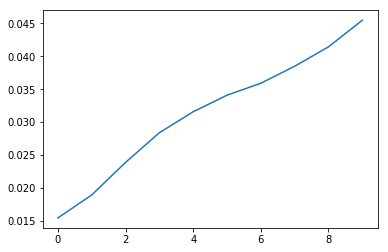

In [49]:
plt.figure()
plt.plot(sat_relative_error_time)
plt.show()

In [24]:
p_relative_error_time = np.mean(np.abs(p_true - p_pred) / (np.max(p_true, axis = (1, 2), keepdims =True) - np.min(p_true, axis = (1, 2), keepdims =True)), axis = (0, 1, 2))

In [25]:
p_relative_error_time

array([0.00601146, 0.00554546, 0.00546052, 0.00583605, 0.00612156,
       0.006285  , 0.00620955, 0.00616871, 0.0062578 , 0.00655761])

In [26]:
np.mean(p_relative_error_time)

0.006045371078082355

In [25]:
p_relative_error_time

array([0.00494534, 0.00471994, 0.00478864, 0.00521211, 0.00553921,
       0.00574387, 0.00570878, 0.0056915 , 0.00579264, 0.00608395])

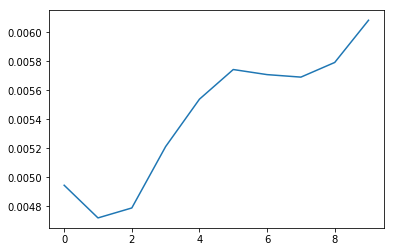

In [26]:
plt.figure()
plt.plot(p_relative_error_time)
plt.show()

In [27]:
np.mean(p_relative_error_time)

0.0054225988254678874